In [1]:
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
def uncond_score(x, expt, m, Gamma_t, label=None, omega=None):
    score = -x/Gamma_t + m * expt / Gamma_t * torch.tanh(torch.dot(x,m)*expt/Gamma_t)
    return score

def cond_score(x, expt, m, Gamma_t, label=0, omega=None):
    if label==0: # we go to +m
        score = (-x+m*expt) / Gamma_t
    else:
        score = (-x-m*expt) / Gamma_t
    return score

def cfg(x, expt, m, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, expt, m, Gamma_t, label)
    cond_score_ = cond_score(x, expt, m, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score_

def new(x, alpha, expt, m, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, expt, m, Gamma_t, label)
    cond_score_ = cond_score(x, expt, m, Gamma_t, label)
    dif = torch.abs(uncond_score_-cond_score_)
    return cond_score_ + dif*omega/(dif**(-alpha)+1.e-6)

# Reverse ODE

In [160]:
num_samples = 100
d = 2
mean, cov = torch.zeros(d), torch.eye(d)
distribution = torch.distributions.MultivariateNormal(mean, cov)
all_samples = distribution.sample((num_samples,))

m = torch.ones(d) * 1.
dt = 0.01
nt = 800
sigma2 = 1.**2
tspec = 1/2*torch.log(torch.tensor([d]))
ns = int(tspec/dt)
omega = 15.
itfms = nt-ns
images_new, x_prev = [], all_samples

alpha=0.5
print("speciation time: ", ns)
for it in tqdm(torch.arange(nt-1)):
    x_cur = []
    scores = []    
    expt=np.exp(-dt*(itfms-it))
    exp2t=expt**2
    Gamma_t=(sigma2*exp2t+1-exp2t)    
    for x in x_prev:
        # score = uncond_score(x, expt, m, Gamma_t)
        score = cond_score(x, expt, m, Gamma_t, label=0)
        # score = cfg(x, expt, m, Gamma_t, omega=omega, label=0)
        # score = new(x, alpha, expt, m, Gamma_t, omega, label=0)
        
        # if nt-it>ns:
        #     # score = new(x,alpha, expt, m, Gamma_t, omega=omega, label=0)
        #     score = cfg(x, expt, m, Gamma_t, omega=omega, label=0)
        # else:
        #     score = cond_score(x, expt, m, Gamma_t, label=0)


        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
        # scores.append(torch.abs(score_c-score_un))

    x_cur = torch.stack(x_cur)
    x_prev = x_cur
    # print(torch.mean(torch.stack(scores)).numpy())
    
print(torch.tensor(x_cur).mean(axis=0))
print(torch.tensor(x_cur).std(axis=0))


speciation time:  34


  0%|          | 0/799 [00:00<?, ?it/s]/tmp/ipykernel_1379386/3340559965.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  expt=np.exp(-dt*(itfms-it))
100%|██████████| 799/799 [00:03<00:00, 210.76it/s]

tensor([0.9852, 0.9418])
tensor([0.7046, 0.6691])



/tmp/ipykernel_1379386/3340559965.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(x_cur).mean(axis=0))
/tmp/ipykernel_1379386/3340559965.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(x_cur).std(axis=0))


# All three moving

In [13]:
sigma = 5.
omega = 25.
dt = 0.01
finish_time = 4.

images_new, x_prev1, x_prev2, x_prev3 = [], all_samples, all_samples, all_samples


timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur1, x_cur2, x_cur3 = [], [], []
    
    for x1, x2, x3 in zip(x_prev1, x_prev2, x_prev3):
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        score1 = cond_score(x1, t_end-t, m1, m2, Gamma_t, label=0)
        score2 = uncond_score(x2, t_end-t, m1, m2, Gamma_t)
        score3 = cfg(x3, t_end-t, m1, m2, Gamma_t, omega=omega, label=0)
        eta = torch.randn_like(x1) * torch.sqrt(torch.tensor(2*dt))
        x_new1 = x1 + 2 * dt * score1 + eta
        x_new2 = x2 + 2 * dt * score2 + eta
        x_new3 = x3 + 2 * dt * score3 + eta
        x_cur1.append(x_new1)
        x_cur2.append(x_new2)
        x_cur3.append(x_new3)
    x_cur1 = torch.stack(x_cur1)
    x_prev1 = x_cur1
    x_cur2 = torch.stack(x_cur2)
    x_prev2 = x_cur2
    x_cur3 = torch.stack(x_cur3)
    x_prev3 = x_cur3    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
    for ax, c in zip(axes, [x_cur1, x_cur2, x_cur3]):
        ax.set_title(['Conditional vec. field, t= %.2f' % (t_end-t), 'Unconditional vec. field, t= %.2f' % (t_end-t), 'CFG vec. field, t= %.2f' % (t_end-t)][axes.tolist().index(ax)])
        ax.scatter(c[:,0].detach().numpy(), c[:,1].detach().numpy(), alpha=0.6)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], color='black', s=25)
            ax.set_xlim(min_val, 10)
            ax.set_ylim(-10, max_val)
            # ax.set_xlim(min_val, max_val)
            # ax.set_ylim(min_val, max_val)
    plt.suptitle("$\omega$ = %.2f" % omega+", and $\sigma$ = %.2f" % sigma)
    plt_path = f'temp_plots/temp_{(t_end-t).item():.2f}.png'

    plt.savefig(plt_path)
    plt.close()
    images_new.append(imageio.imread(plt_path))




imageio.mimsave('demo/2d_sim_overshoot2_good.gif', images_new, fps=20)

  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [04:27<00:00,  1.50it/s]


In [11]:
# ask urself and see in exps; can u get the combination of sigma and omega where the variance of the original is a bit too large so the conditional vector field itself doesn't go all the way but the CFG pushes it a bit too much towards the mean, i.e. pushes it a bit further than usual nonconditional cfg would?

# Only two moving

In [10]:
sigma = 5.
omega = 25.
dt = 0.05
finish_time = 4.

x_prev1, x_prev3, x_prev4 = all_samples, all_samples, all_samples


timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur1, x_cur3, x_cur4 = [], [], []
    
    for x1, x3, x4 in zip(x_prev1, x_prev3, x_prev4):
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        score1 = cond_score(x1, t_end-t, m1, m2, Gamma_t, label=0)
        score3 = cfg(x3, t_end-t, m1, m2, Gamma_t, omega=omega, label=0)
        
        score_un = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        score_c = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        score4 = score_c + (score_c-score_un)*torch.clip((torch.abs(score_c-score_un))**0.5,max=1000)
        
        eta = torch.randn_like(x1) * torch.sqrt(torch.tensor(2*dt))
        x_new1 = x1 + 2 * dt * score1 + eta
        x_new3 = x3 + 2 * dt * score3 + eta
        x_new4 = x4 + 2 * dt * score4 + eta
        x_cur1.append(x_new1)
        x_cur3.append(x_new3)
        x_cur4.append(x_new4)
    x_cur1 = torch.stack(x_cur1)
    x_prev1 = x_cur1
    x_cur3 = torch.stack(x_cur3)
    x_prev3 = x_cur3    
    x_cur4 = torch.stack(x_cur4)
    x_prev4 = x_cur4

100%|██████████| 81/81 [00:16<00:00,  4.78it/s]


In [31]:
mean_vector = m1-m2
cov_matrix = torch.eye(2) * sigma
distribution = torch.distributions.MultivariateNormal(mean_vector, cov_matrix)

# Sample from the distribution
true_samples = distribution.sample((num_samples,))

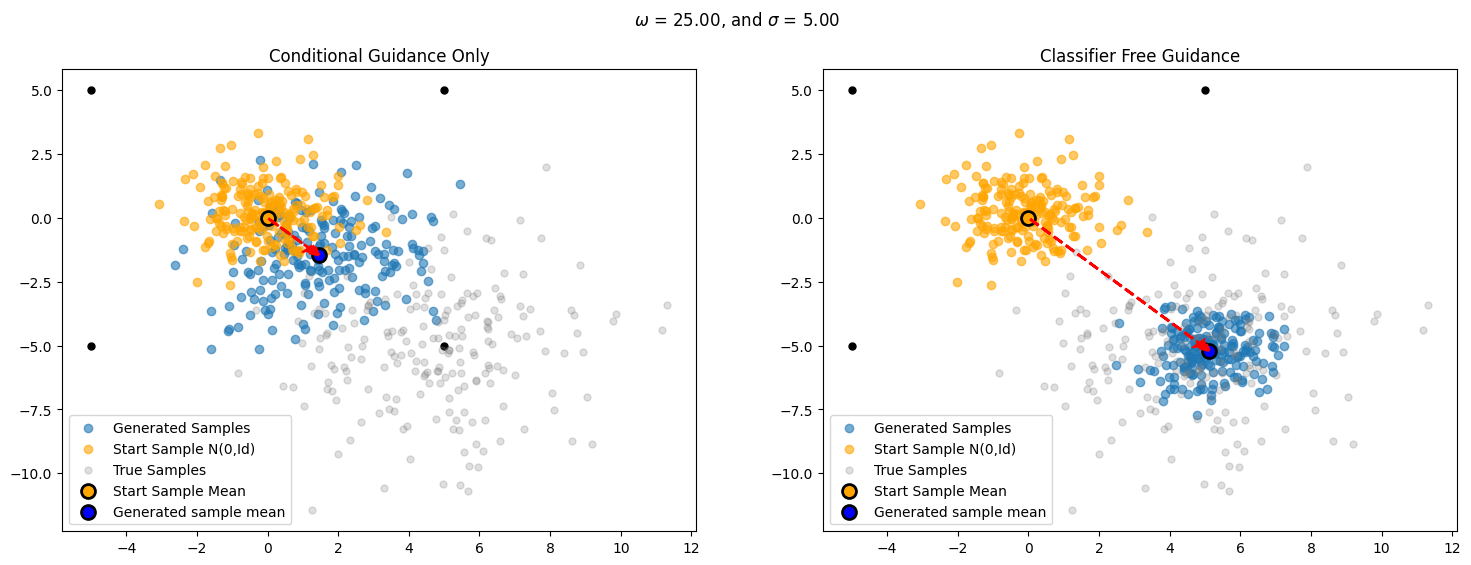

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create 3 subplots side by side
for ax, c in zip(axes, [x_cur1, x_cur3]):
    ax.set_title(['Conditional Guidance Only' % t, 'Classifier Free Guidance' % t][axes.tolist().index(ax)])
    ax.scatter(*c.T, alpha=0.6, label='Generated Samples')
    ax.scatter(*all_samples.T, alpha=0.6, color='orange', label='Start Sample N(0,Id)')
    for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
        ax.scatter(plots[0], plots[1], color='black', s=25)
    ax.scatter(*true_samples.T, s=25, color='grey', alpha=0.25, label='True Samples')
    ax.scatter(0,0, s=100, color='orange', edgecolor='black', linewidth=2, label='Start Sample Mean')
    ax.scatter(c.mean(axis=0)[0],c.mean(axis=0)[1], s=100, color='blue', edgecolor='black', linewidth=2, label='Generated sample mean')
    x_start, y_start, x_end, y_end = 0., 0., c.mean(axis=0)[0], c.mean(axis=0)[1]
    ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, length_includes_head=True, head_width=0.4, head_length=0.4, fc='r', ec='r',
         linestyle='--', linewidth=2)
    ax.legend()
plt.suptitle("$\omega$ = %.2f" % omega+", and $\sigma$ = %.2f" % sigma)
plt.show()

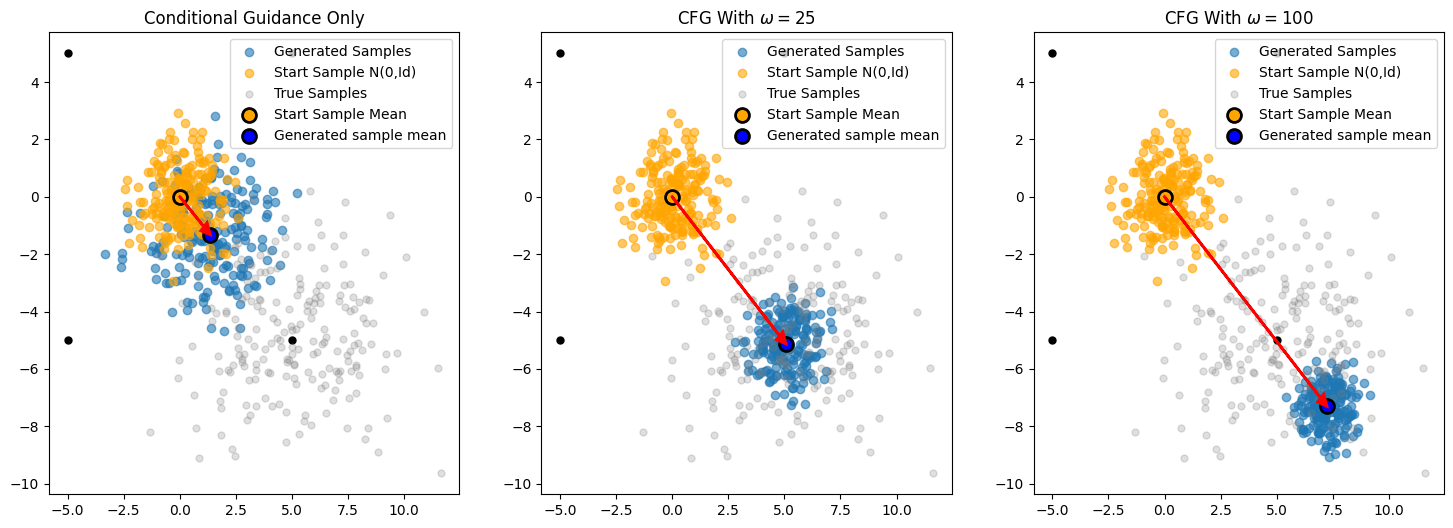

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
for ax, c in zip(axes, [x_cur1, x_cur3, x_cur4]):
    ax.set_title(['Conditional Guidance Only', 'CFG With $\omega=25$', 'CFG With $\omega=100$'][axes.tolist().index(ax)])
    ax.scatter(*c.T, alpha=0.6, label='Generated Samples')
    ax.scatter(*all_samples.T, alpha=0.6, color='orange', label='Start Sample N(0,Id)')
    for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
        ax.scatter(plots[0], plots[1], color='black', s=25)
    ax.scatter(*true_samples.T, s=25, color='grey', alpha=0.25, label='True Samples')
    ax.scatter(0,0, s=100, color='orange', edgecolor='black', linewidth=2, label='Start Sample Mean')
    ax.scatter(c.mean(axis=0)[0],c.mean(axis=0)[1], s=100, color='blue', edgecolor='black', linewidth=2, label='Generated sample mean')
    x_start, y_start, x_end, y_end = 0., 0., c.mean(axis=0)[0], c.mean(axis=0)[1]
    ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, length_includes_head=True, head_width=0.4, head_length=0.4, fc='r', ec='r', linewidth=2)
    ax.legend()
# plt.suptitle("$\omega$ = %.2f" % omega+", and $\sigma$ = %.2f" % sigma)
plt.savefig('paper_figs/2d_cfg_good_bad.pdf')
plt.show()

# Difference of scores

In [21]:
def vecc(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(- torch.dot(m1 , m2) * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(torch.dot(m1 , m2) * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.matmul(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.matmul(x, (m1 - m2))


    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom).reshape(-1,1)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom).reshape(-1,1)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom).reshape(-1,1)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom).reshape(-1,1)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t

In [25]:
sigma = 1.
a = 1.
diffs = []
all_samples = []
t_end = 4.
omega = 100.

for t in (torch.linspace(0,4,60)):
    diffs_1 = []
    for d in (torch.linspace(1,60,10).round()+1)*2:
        m1, m2 = a * torch.cat((torch.zeros(int(d/2)), torch.ones(int(d/2)))), -a * torch.cat((torch.ones(int(d/2)), torch.zeros(int(d/2))))
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt

        means = [m1-m2]
        cov = torch.eye(int(d)) * sigma
        weight = 0.25
        num_samples = 200
        samples = []
        for mean in means:
            num_samples_gaussian = int(num_samples * weight)
            distribution = torch.distributions.MultivariateNormal(mean, cov)
            samples_gaussian = distribution.sample((num_samples_gaussian,))
            samples.append(samples_gaussian)

        all_samples = torch.cat(samples)
        diffs_1.append(((vecc(all_samples, t, m1, m2, Gamma_t, label=0, omega=omega)-cond_score(all_samples, t, m1, m2, Gamma_t, label=0))**2).mean())
    diffs.append(diffs_1)

In [30]:
diffs = np.array(diffs)
print(diffs.shape)

(60, 10)


In [45]:
def moving_average(arr, window):
    n = len(arr)
    moving_averages = []
    for i in range(n - window + 1):
        window_sum = sum(arr[i:i+window])
        window_average = window_sum / window
        moving_averages.append(window_average)
    return moving_averages

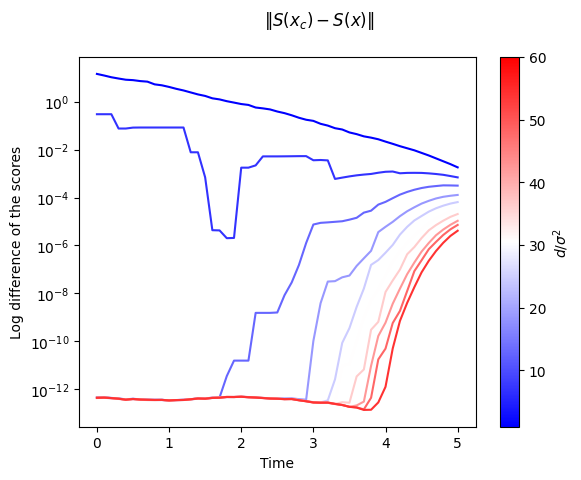

In [67]:
from scipy.signal import savgol_filter

cmap = plt.get_cmap('bwr')  # You can choose other colormaps like 'plasma', 'inferno', etc.
# Create a figure and axis
fig, ax = plt.subplots()
# Plot each line with a color from the colormap
for i, lin in enumerate(diffs.T):
    # ax.plot(lin, color=cmap(i / diffs.shape[1]))
    av = moving_average(lin,10)
    ax.plot(np.arange(len(av)), av, color=cmap(i / diffs.shape[1]))

ax.set_xticks([0, 10, 20, 30, 40 ,50], [0, 1, 2,3, 4, 5])
ax.set_yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=60))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('$d/\sigma^2$')
plt.xlabel('Time')
plt.ylabel('Log difference of the scores')
plt.suptitle(f'$\|S(x_c)-S(x)\|$')
plt.savefig('paper_figs/score_diffs.pdf')
plt.show()

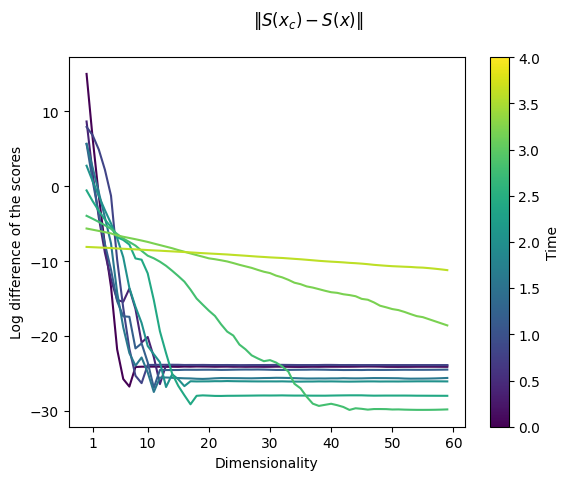

In [36]:
from scipy.signal import savgol_filter

cmap = plt.get_cmap('viridis')  # You can choose other colormaps like 'plasma', 'inferno', etc.
# Create a figure and axis
fig, ax = plt.subplots()
# Plot each line with a color from the colormap
for i, lin in enumerate(torch.tensor(diffs).numpy()):
    color = cmap(i / len(diffs))  # Get a color from the colormap
    # ax.plot(np.log(lin.T), label=f'{torch.linspace(0, 4, 10)[i]:.2f}', color=color)
    ax.plot(savgol_filter(np.log(lin.T), 10, 2), label=f'{torch.linspace(0, 4, 10)[i]:.2f}', color=color)
# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=4))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time')
plt.xlabel('Dimensionality')
plt.xticks([1,10,20,30,40,50,60])
plt.ylabel('Log difference of the scores')
plt.suptitle(f'$\|S(x_c)-S(x)\|$')
plt.savefig('paper_figs/score_diffs.pdf')
plt.show()